In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from pathlib import Path

In [10]:
# Use seaborn theme
sns.set_theme(style="white", context="paper")

# Set your mpl settings
mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["savefig.dpi"] = 600
mpl.rcParams["savefig.transparent"] = True
mpl.rcParams["font.size"] = 40
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial"]
mpl.rcParams["axes.titlesize"] = "xx-large"
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["axes.labelsize"] = 30
mpl.rcParams["xtick.labelsize"] = 30
mpl.rcParams["ytick.labelsize"] = 30
mpl.rcParams["text.color"] = 'black'

In [11]:
# scale
px_per_mm = 10.6

In [12]:
# Read csv with metrics for each trained model
df_summary = pd.read_csv("sample_efficiency_summary.csv")
df_summary = df_summary.copy()

In [13]:
# Print unique datasets
df_summary['Dataset'].unique()

array(['Rice (10 DAG, crown)', 'Rice (3 DAG, primary)',
       'Rice (3 DAG, crown)', 'Soybean (5-8 DAG, lateral)',
       'Soybean (5-8 DAG, primary)', 'Arabidopsis (7 DAG, lateral)',
       'Arabidopsis (7 DAG, primary)', 'Canola (5-13 DAG, lateral)',
       'Canola (5-13 DAG, primary)'], dtype=object)

c:\ProgramData\mambaforge\envs\berrigan_et_al\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\mambaforge\envs\berrigan_et_al\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


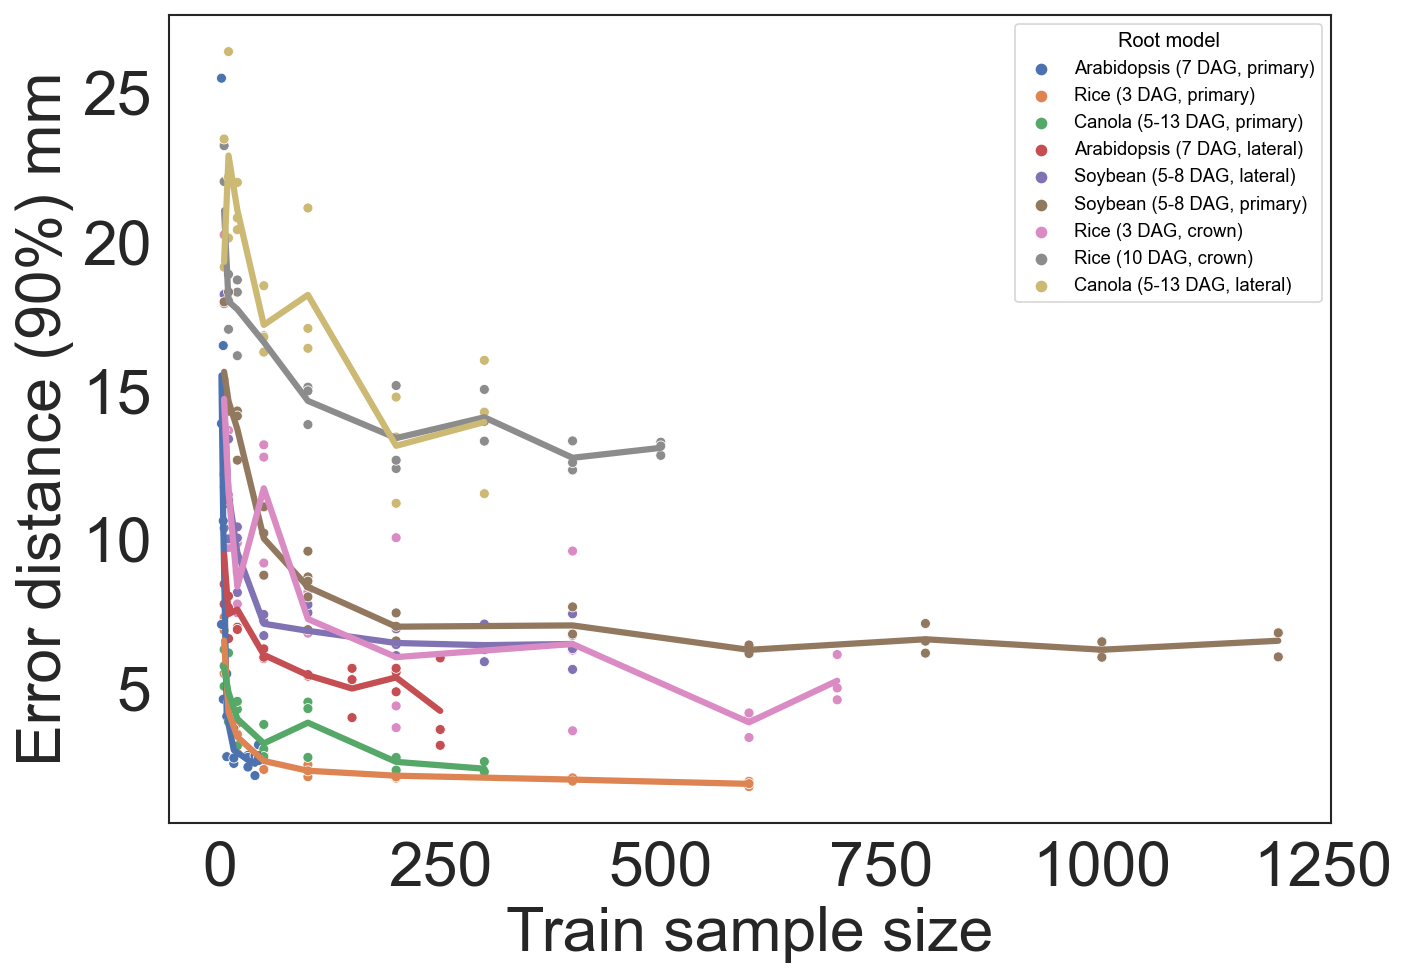

In [14]:
plt.figure(figsize=(10, 7))

# Define the desired order of the dataset hue
hue_order = ["Arabidopsis (7 DAG, primary)", "Rice (3 DAG, primary)", "Canola (5-13 DAG, primary)",
             "Arabidopsis (7 DAG, lateral)", "Soybean (5-8 DAG, lateral)", "Soybean (5-8 DAG, primary)", 
             "Rice (3 DAG, crown)", "Rice (10 DAG, crown)", "Canola (5-13 DAG, lateral)"]

# Create a scatter plot with the specified hue order
ax = sns.scatterplot(x="Train sample size", y="Error distance (90%) mm", hue="Dataset", hue_order=hue_order, data=df_summary)
# Add a line plot to the same axis
ax = sns.lineplot(x="Train sample size", y="Error distance (90%) mm", hue="Dataset", hue_order=hue_order, errorbar=None, data=df_summary, legend=False, lw=3)

# Set a custom legend with hue order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=hue_order, title="Root model")

# Save the figure
plt.savefig(r"sample_efficiency_all_models.png", bbox_inches = "tight", facecolor="white")

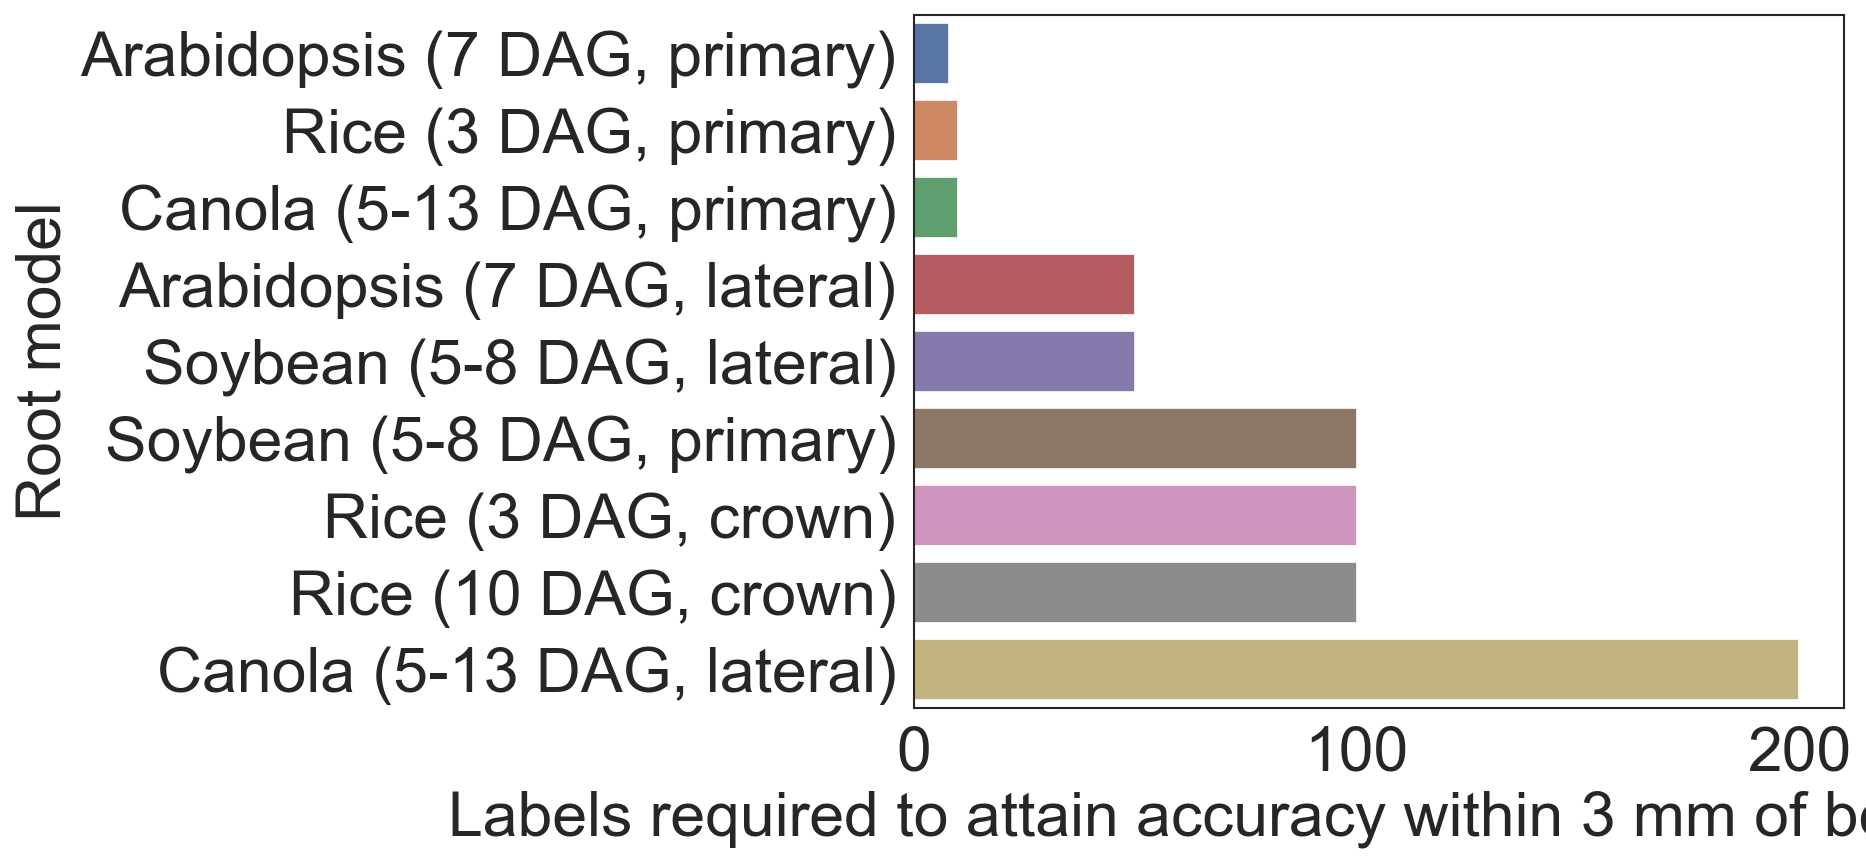

In [15]:
# Threshold used to determine if a model accuracy has plateaued with respect to number of labeled frames in training set
threshold = 3  # mm

# Define the desired order of the dataset hue
hue_order = ["Arabidopsis (7 DAG, primary)", "Rice (3 DAG, primary)", "Canola (5-13 DAG, primary)",
             "Arabidopsis (7 DAG, lateral)", "Soybean (5-8 DAG, lateral)", "Soybean (5-8 DAG, primary)", 
             "Rice (3 DAG, crown)", "Rice (10 DAG, crown)", "Canola (5-13 DAG, lateral)"]

# Define accuracy using threshold
def is_accurate(df):
    # Calculate the minimum error distance (90%) within each dataset
    min_error = df["Error distance (90%) mm"].min()
    # Determine accuracy based on the threshold
    df["is_accurate"] = (df["Error distance (90%) mm"] - min_error) < threshold
    return df

# Calculate the medians of the 90th percentile error distance for each combination of dataset and train sample size
df_median = df_summary.groupby(["Dataset", "Train sample size"])["Error distance (90%) mm"].median().reset_index()

# Apply the accuracy function to each group and reset the index afterwards
df_accurate = df_median.groupby("Dataset").apply(is_accurate).reset_index(drop=True)

# Filter the dataframe to only include the first instance of each dataset where the model is accurate
df_filtered = df_accurate[df_accurate["is_accurate"]].sort_values(by=["Dataset", "Train sample size"]).drop_duplicates("Dataset", keep='first').drop("is_accurate", axis=1)

# Plot the figure
plt.figure(figsize=(8, 6))
sns.barplot(x="Train sample size", y="Dataset", data=df_filtered, order=hue_order)
plt.xlabel("Labels required to attain accuracy within 3 mm of best performance")
plt.ylabel("Root model")
plt.savefig("number_labeled_frames_required_for_accurate_predictions.png", bbox_inches="tight", facecolor="white")


In [16]:
# Save the results to a csv
df_filtered.to_csv(f"number_of_labels_for_minimally_accurate_model.csv", index=False)